In [1]:
# Standard stuff
import numpy as np                              #For almost everything
import matplotlib.pyplot as plt                 #For plotting
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages       #For saving figures to single pdf
figlist = []

#*******************************************************************************************************
#Setting RC Parameters for figure size and fontsizes
import matplotlib.pylab as pylab                           
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
#********************************************************************************************************

# Import pyliso tools
from pyliso import Circuit, save, load
from plotting import plotTF, plotTFs
import copy

mList = ['o','v','^','<','>','s','p','*','H','+','X','D']
cList = ['b','g','r','c','m','y','k']

In [4]:
FSS = Circuit('linux')
FSS.parseFil('FSS_all.fil')
fflow = 1
ffhigh = 1.0e8
numPoints = 8000
FSSAnalysis = {}   #Dictionary of FSS object at different instances of analysis

########################
#   Parsing complete   #
########################



In [5]:
def chooseInput(FSS,opt):
    if opt is 'RF':
        FSS.removeParts(['rfbr10'])
        if 'rfbr9' not in FSS.parts.keys():
            FSS.addResistor('rfbr9',22.0,'rfbn1','rfbn2')
        print('Use input node rfbn1.')
    elif opt is 'TESTRFB':
        FSS.removeParts(['rfbr9'])
        if 'rfbr10' not in FSS.parts.keys():
            FSS.addResistor('rfbr10',100.0,'rfbn2','gnd')
        print('Use input node rfbn2.')
    else:
        print('Error: Use options RF or TESTRFB')
        print('Nothing changed.')

def engageCOMTest(FSS,switch):
    if switch is 'ON':
        FSS.removeParts(['comr13'])
        if 'comr12' not in FSS.parts.keys():
            FSS.addResistor('comr12',49.9,'comn7','gnd')
        if 'comout1' not in FSS.parts.keys():
            FSS.addResistor('comout1',50.0,'comn5','gnd')
        if 'comout2' not in FSS.parts.keys():
            FSS.addResistor('comout2',50.0,'comn6','gnd')
        print('Use input node comn7 for excitation.')
        print('OUT1 node is comn5')
        print('OUT2 node is comn6')
    elif switch is 'OFF':
        FSS.removeParts(['comr12'])
        FSS.removeParts(['comout1'])
        FSS.removeParts(['comout2'])
        if 'comr13' not in FSS.parts.keys():
            FSS.addResistor('comr13',1e3,'comn7','gnd')
        print('COM Excitation port not connected.')
    else:
        print('Error: Use switch position ON or OFF')
        print('Nothing changed.')

def engagePZTTest(FSS,switch):
    if switch is 'ON':
        FSS.removeParts(['pztr51'])
        if 'pztr50' not in FSS.parts.keys():
            FSS.addResistor('pztr50',50.0,'pztn12b','gnd')
        if 'pztr45load' not in FSS.parts.keys():
            FSS.addResistor('pztr45load',50.0,'pztJ7','gnd')
        if 'pztr42load' not in FSS.parts.keys():
            FSS.addResistor('pztr42load',50.0,'pztJ5','gnd')
        print('Use input node pztn12b for excitation.')
        print('OUT1 node is pztJ7')
        print('OUT2 node is pztJ5')
    elif switch is 'OFF':
        FSS.removeParts(['pztr50'])
        FSS.removeParts(['pztr45load'])
        FSS.removeParts(['pztr42load'])
        if 'pztr51' not in FSS.parts.keys():
            FSS.addResistor('pztr51',1e3,'pztn12b','gnd')
        print('PZT Excitation port not connected.')
    else:
        print('Error: Use switch position ON or OFF')
        print('Nothing changed.')
        
def PZTBoost(FSS,switch):
    if switch is 'ON':
        FSS.removeParts(['pztrs35'])
        if 'pztc35' not in FSS.parts.keys():
            FSS.addCapacitor('pztc35',6.8e-9,'pztn8i','pztn9')
        print('PZT Boost is ON.')
    elif switch is 'OFF':
        FSS.removeParts(['pztc35'])
        if 'pztrs35' not in FSS.parts.keys():
            FSS.addResistor('pztrs35',0.0,'pztn8i','pztn9')
        print('PZT Boost is OFF.')
    else:
        print('Error: Use switch position ON or OFF')
        print('Nothing changed.')

def PZTSign(FSS,sign):
    if sign is '+':
        FSS.removeParts(['pzts1'])
        FSS.addResistor('pzts1',0.0,'pztn13','pztn14')
        print('Positive sign is chosen after PZT stage 5.')
    elif sign is '-':
        FSS.removeParts(['pzts1'])
        FSS.addResistor('pzts1',0.0,'gnd','pztn14')
        print('Negative sign is chosen after PZT stage 5.')
    else:
        print('Error: Use sign + or -')
        print('Nothing changed.')
        
def AD602gain(Cir,name,G=None,Vg=None,vb=True):
    if G is None:
        if Vg is None:
            print('Error: Provide gain in dB or gain setting voltage in V.')
            print('Nothing changed.')
            return 0
        else:
            G = 32.0*Vg + 10.0
    if G>30.0 or G<-10.0:
        print('Error: Gain can be set between -10dB to 30 dB only.')
        print('Nothing changed.')
        return 0
    r1 = 100.0 - (10**(G/20.0))/0.357
    r2 = 100.0 - r1
    Cir.parts['AD602'+name+'rg1'].value=r1
    Cir.parts['AD602'+name+'rg2'].value=r2
    if vb:
        print('Gain set to '+str(np.round(G,2))+' dB.')
    
def COMGain(FSS,G=None,Vg=None,vb=True):
    if vb:
        print('Setting common gain:')
    AD602gain(FSS,'u2a',G,Vg,vb)
    
def PZTGain(FSS,G=None,Vg=None,vb=True):
    if vb:
        print('Setting pzt path gain (Fast Gain):')
    AD602gain(FSS,'u2b',G,Vg,vb)

### [PSL:893 Changes](https://nodus.ligo.caltech.edu:8081/PSL_Lab/893)

In [6]:
FSS.parts['comr1'].value = 49.9
FSS.parts['comr2'].value = 49.9
FSS.parts['comr7'].value = 49.9
FSS.parts['comr4'].value = 402.0
FSS.parts['comr3'].value = 56.0

### [PSL:1140 Changes](https://nodus.ligo.caltech.edu:8081/PSL_Lab/1140)

In [7]:
FSS.parts['comr1'].value = 47.0
FSS.parts['comr2'].value = 47.0
FSS.parts['comr7'].value = 47.0
FSS.parts['comr4'].value = 390.0
FSS.parts['comr3'].value = 100.0
FSS.parts['pztr29'].value = 5.1e3
FSS.parts['pztc35'].value = 6.8e-9
FSS.parts['pztrs35'].value = 0

### [PSL:1918 Changes](https://nodus.ligo.caltech.edu:8081/PSL_Lab/1918)

In [8]:
FSS.parts['comr1'].value = 470.0
FSS.parts['comr2'].value = 470.0

### [PSL:1926 Changes](https://nodus.ligo.caltech.edu:8081/PSL_Lab/1926)

In [9]:
FSS.parts['comr1'].value = 453.0
FSS.parts['comr2'].value = 453.0

### [PSL:1989 Changes](https://nodus.ligo.caltech.edu:8081/PSL_Lab/1989)

In [10]:
FSS.parts['comr1'].value = 453.0
FSS.parts['comr2'].value = 453.0
FSS.parts['comr7'].value = 100.0
FSS.parts['comr3'].value = 124.0

In [11]:
### [PSL:2238 Changes](https://nodus.ligo.caltech.edu:8081/PSL_Lab/2238)

In [12]:
FSS.parts['rfbl3'].value = 750e-9
FSS.parts['rfbc12'].value = 24.4e-12            #On south side this is 22pF. Doesn't affect our results.

### [PSL:2302 Changes](https://nodus.ligo.caltech.edu:8081/PSL_Lab/2302)

In [13]:
FSS.parts['eomc24'].value = 100e-9
FSS.parts['eomc23'].value = 33e-9
FSS.parts['eomr19'].value = 2e3
FSS.parts['pztc36'].value = 560e-12

### [PSL:2303 Changes](https://nodus.ligo.caltech.edu:8081/PSL_Lab/2303)

In [14]:
FSS.parts['pztr29'].value = 5.6e3                  #Changed back to thin film 5.6k on both FSS boxes 02/05/2018

In [15]:
# Setting sign to negative after stage 5 in PZT path
PZTSign(FSS,'+')
# Setting Common and Fast (PZT) gains:
COMGainValue = 0.4    #dB
PZTGainValue = 46.8    #dB
COMGain(FSS,G=COMGainValue)
PZTGain(FSS,G=PZTGainValue)

Positive sign is chosen after PZT stage 5.
Setting common gain:
Gain set to 0.4 dB.
Setting pzt path gain (Fast Gain):
Error: Gain can be set between -10dB to 30 dB only.
Nothing changed.


In [16]:
FSS.parts['comr2']

comr2 is a 4.530000e+02 Ohm resistor

## Transfer function analysis
Transfer functions from RFinput to PZT output (pztn17) and EOM (eomHVn11) output.

First, some poles and zeros calculations.

In [19]:
PZTpoles = {}
PZTzeros = {}
PZTnotch = {}
PZTpoles[r'PZT,$f_p=\frac{1}{2\pi C_{36}R_{30}}$'] = 1/(2*np.pi*FSS.parts['pztc36'].value*FSS.parts['pztr30'].value)
PZTpoles[r'PZT,$f_p=\frac{1}{2\pi C_{37}R_{31}}$'] = 1/(2*np.pi*FSS.parts['pztc37'].value*FSS.parts['pztr31'].value)
PZTpoles[r'PZT,$f_p=\frac{1}{2\pi (C_{51}+C_{pzt})R_{46}}$'] = 1/(2*np.pi*(FSS.parts['pztc51'].value+FSS.parts['pztclaser'].value)*FSS.parts['pztr46'].value)
PZTnotch[r'PZT,$f_n=\frac{1}{2\pi \sqrt{L_2(C_{47}+C_{46})}}$'] = 1/(2*np.pi*np.sqrt((FSS.parts['pztc46'].value+FSS.parts['pztc47'].value)*FSS.parts['pztl2'].value))
PolesNZeros = dict(PZTpoles,**PZTnotch)

EOMpoles = {}
EOMzeros = {}
EOMnotch = {}
EOMpoles[r'EOM,$f_p=\frac{1}{2\pi C_{23}R_{22}}$'] = 1/(2*np.pi*FSS.parts['eomc23'].value*FSS.parts['eomr22'].value)
EOMpoles[r'EOM,$f_p=\frac{1}{2\pi C_{15}R_{19}}$'] = 1/(2*np.pi*FSS.parts['eomc15'].value*FSS.parts['eomr19'].value)
EOMpoles[r'EOM,$f_p=\frac{1}{2\pi C_{24}R_{24}}$'] = 1/(2*np.pi*FSS.parts['eomc24'].value*FSS.parts['eomr24'].value)
EOMpoles[r'EOM,$f_p=\frac{1}{2\pi C_{16(}R_{20+}R_{18)}}$'] =  1/(2*np.pi*(FSS.parts['eomr20'].value+FSS.parts['eomr18'].value)*FSS.parts['eomc16'].value)
EOMpoles[r'EOM,$f_p=\frac{1}{2\pi C_{18}R_{20}}$'] = 1/(2*np.pi*FSS.parts['eomc18'].value*FSS.parts['eomr20'].value)
EOMpoles[r'EOM,$f_p=\frac{1}{2\pi C_{25}R_{25}}$'] = 1/(2*np.pi*FSS.parts['eomc25'].value*FSS.parts['eomr25'].value)
PolesNZeros = dict(PolesNZeros,**EOMpoles)
EOMzeros[r'EOM,Zero->EOM'] = 0
EOMzeros[r'EOM,Zero->C23'] = 0
EOMzeros[r'EOM,Zero->C24'] = 0
EOMzeros[r'EOM,Zero->C25'] = 0
EOMzeros[r'EOM,$f_z=\frac{1}{2\pi C_{16}R_{18}}$'] = 1/(2*np.pi*FSS.parts['eomc16'].value*FSS.parts['eomr18'].value)
EOMnotch[r'EOM,$f_n=\frac{1}{2\pi \sqrt{L_1C_{13}}}$'] = 1/(2*np.pi*np.sqrt(FSS.parts['eomc13'].value*FSS.parts['eoml1'].value))
PolesNZeros = dict(PolesNZeros,**EOMzeros,**EOMnotch)

----


### Boost ON

In [20]:
chooseInput(FSS,'RF') #Choosing RF input
engageCOMTest(FSS,'OFF')
engagePZTTest(FSS,'OFF')
PZTBoost(FSS,'ON')

PZTBoostpoles = {}
PZTBoostzeros = {}
PZTBoostpoles[r'PZTBoost,Pole'] = 0
PZTBoostzeros[r'PZTBoost,$f_z=\frac{1}{2\pi C_{35}R_{29}}$'] = 1/(2*np.pi*FSS.parts['pztc35'].value*FSS.parts['pztr29'].value)
PolesNZeros = dict(PolesNZeros,**PZTBoostpoles,**PZTBoostzeros)

Use input node rfbn1.
COM Excitation port not connected.
PZT Excitation port not connected.
PZT Boost is ON.


#### RFinput to PZT output

In [21]:
FSS.computeTF('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
FSS.computeNoise('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
FSS.computeAllNoises('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
FSS.computeInNoise('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
FSS.computeAllInNoises('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
FSSAnalysis['RFIN-PZTout_BoostON'] = copy.deepcopy(FSS)
ff = FSS.ff

#### RFinput to EOM output

In [22]:
FSS.computeTF('rfbn1', 'eomHVn11', fflow, ffhigh, numPoints)
FSS.computeNoise('rfbn1', 'eomHVn11', fflow, ffhigh, numPoints)
FSS.computeAllNoises('rfbn1', 'eomHVn11', fflow, ffhigh, numPoints)
FSS.computeInNoise('rfbn1', 'eomHVn11', fflow, ffhigh, numPoints)
FSS.computeAllInNoises('rfbn1', 'eomHVn11', fflow, ffhigh, numPoints)
FSSAnalysis['RFIN-EOMout'] = copy.deepcopy(FSS)


----


### Boost OFF

In [23]:
PZTBoost(FSS,'OFF')

PZT Boost is OFF.


#### RFinput to PZT output

In [24]:
FSS.computeTF('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
FSS.computeNoise('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
FSS.computeAllNoises('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
FSS.computeInNoise('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
FSS.computeAllInNoises('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
FSSAnalysis['RFIN-PZTout_BoostOFF'] = copy.deepcopy(FSS)

---

### Converting to frequency actuation units

#### Sensor conversion slope

Incoming signal at RF input is in volts after mixer. This is related to frequency error by PDH discriminant ( [Black et al. Am. J. Phys., 69, 1 (2001)](https://aapt.scitation.org/doi/pdf/10.1119/1.1286663?class=pdf) (Eq 4.2):

$D = -\frac{8\sqrt{P_CP_S}}{\delta \nu}\,\,\,\frac{W}{Hz}$

where $P_C = J_0^2(\beta)$ is carrier power, $P_S = J_1^2(\beta)$ is the sideband power, $\beta$ being modulation index, and $\delta \nu = \Delta \nu_{FSR}/\mathcal{F}$ is cavity linewidth, $\Delta \nu_{FSR} = c/2L$ being free spectral range and $\mathcal{F}$ being the cavity finesse. This approximates to:

$D = -\frac{4 P_0 \beta}{\frac{c}{2L}}\,\mathcal{F}\,\,\,\frac{W}{Hz}$ 

Where $P_0$ is incident power and $L$ is cavity length. The RFPDs gain and transimpedance converts this into V/Hz. So our sensors frequency error to V conversion is:

$S_{Sensor} = -Z_{TI} \mathcal{R} \frac{8P_0\beta L}{c}\mathcal{F}\,\,\,\frac{V}{Hz}$

where $Z_{TI}$ is transimpedance gain of RFPD amplifier and $\mathcal{R}$ is the photodiode's responsivity.

#### PZT actuation slope

PZT actuation slope is directly marked on the laser as 1 MHz/V. So

$S_{PZT} = 10^6 \,\,\,\frac{Hz}{V}$

#### EOM actuation slope

EOM actuates on the phase of the laser, not the frequency directly. [New Focus 4004](https://www.newport.com/medias/sys_master/images/images/h65/hcc/8797007839262/400X-and-406X-User-Manual-Rev-J.pdf) has a modulation slope of $m_s = 15 mrad/V$. The rate of change of the phase acts as frequency change by the EOM:

$ \delta f(t) = \frac{1}{2\pi}\frac{d \Delta\phi}{dt} = \frac{m_s}{2\pi} \frac{d V_{EOM}}{dt}$

Therefore, in fourier domain,

$ \tilde{\delta f(f)} = \frac{m_s}{2\pi} (-\iota 2 \pi f) \tilde{V_{EOM}(f)}$

Therefore, the actuation slope for the EOM is:

$S_{EOM} = -\iota f m_s  \,\,\,\frac{Hz}{V}$

In [25]:
Z_TI = 2.5e3   # V/A, RFPD transimpedance
Res = 0.75     # A/W, Photodiode responsivity
F =  150000    # Cavity finesse
P0 = 1.5e3     # W, Incident power on cavity
beta = 0.3     # PDH modulation index
L = 3.8e-2     # m, Cavity Length
c = 3e8        # m/s Speed of light
ms = 15e-3     # rad/V EOM modulation slope

S_sensor = - Z_TI*Res*8.0*P0*beta*L*F/c  #V/Hz

S_PZT = 1e6                              # Hz/V

S_EOM = -1j*ff*ms                     #Hz/V

In [26]:
plotDict1 = {}
plotDict1['TF PZT Path, Boost ON'] = (S_PZT/S_sensor)*FSSAnalysis['RFIN-PZTout_BoostON'].TF
plotDict1['TF EOM Path'] = (S_EOM/S_sensor)*FSSAnalysis['RFIN-EOMout'].TF
plotDict1['TF PZT Path, Boost OFF'] = (S_PZT/S_sensor)*FSSAnalysis['RFIN-PZTout_BoostOFF'].TF

TypeError: 'dict_items' object is not subscriptable

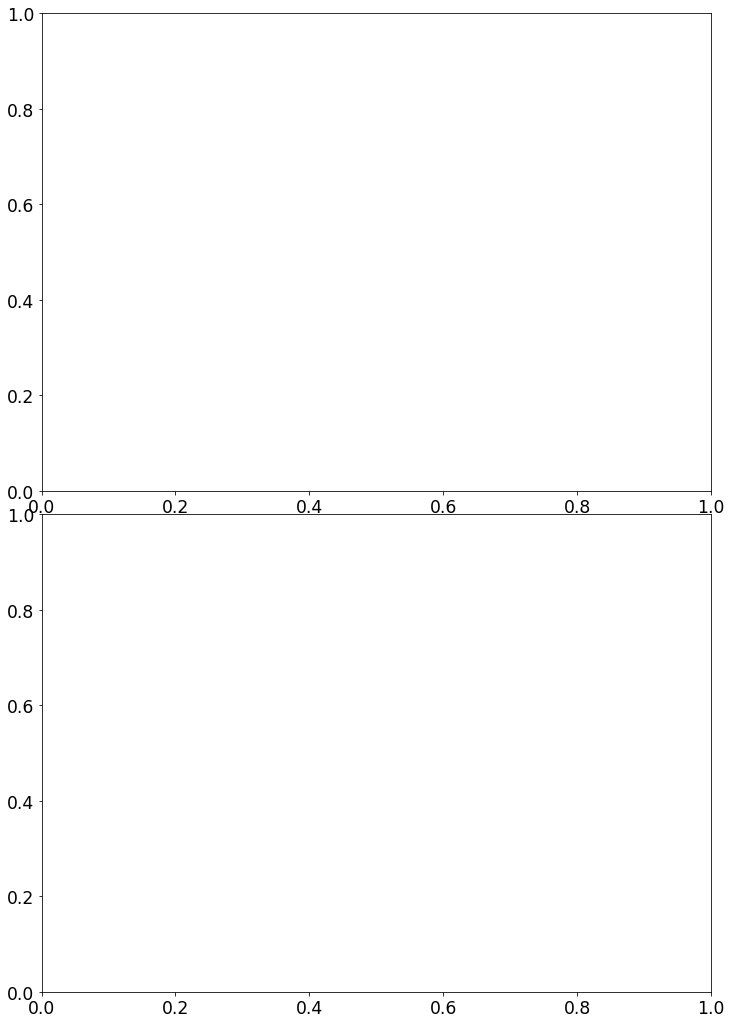

In [27]:
fig1 = plt.figure(figsize=[12,18])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
mag_ax = fig1.add_subplot(gs[0])
phase_ax = fig1.add_subplot(gs[1], sharex=mag_ax)
plotTFs(ff,plotDict1,mag_ax=mag_ax,phase_ax=phase_ax,linewidth=2)
mag_ax.set_title('Transfer functions of actuation paths.\nCOM Gain = '+str(COMGainValue)+' dB, PZT Gain = '+str(PZTGainValue)+' dB')
mag_ax.plot(ff,np.ones(len(ff)),c='k')
figlist +=[fig1]

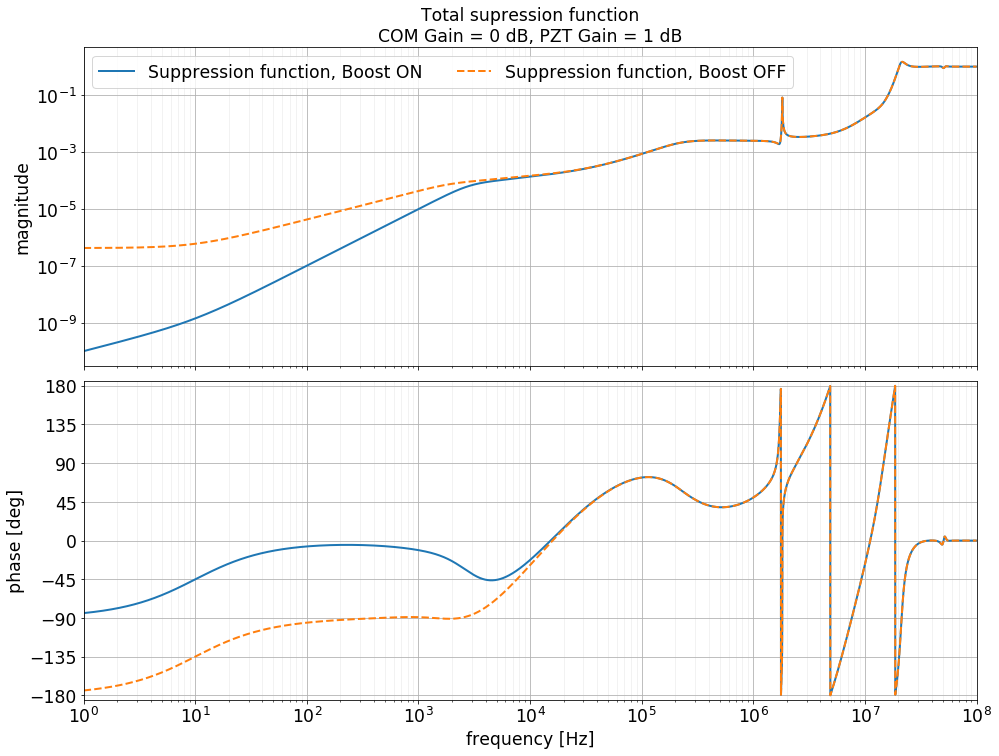

In [23]:
plotDict1a = {}
plotDict1a['Suppression function, Boost ON'] = 1/(1-plotDict1['TF PZT Path, Boost ON'] - plotDict1['TF EOM Path'])
plotDict1a['Suppression function, Boost OFF'] = 1/(1-plotDict1['TF PZT Path, Boost OFF'] - plotDict1['TF EOM Path'])
fig1a = plt.figure(figsize=[16,12])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
mag_ax = fig1a.add_subplot(gs[0])
phase_ax = fig1a.add_subplot(gs[1], sharex=mag_ax)
plotTFs(ff,plotDict1a,mag_ax=mag_ax,phase_ax=phase_ax,linewidth=2)
mag_ax.set_title('Total supression function\nCOM Gain = '+str(COMGainValue)+' dB, PZT Gain = '+str(PZTGainValue)+' dB')
figlist +=[fig1a]

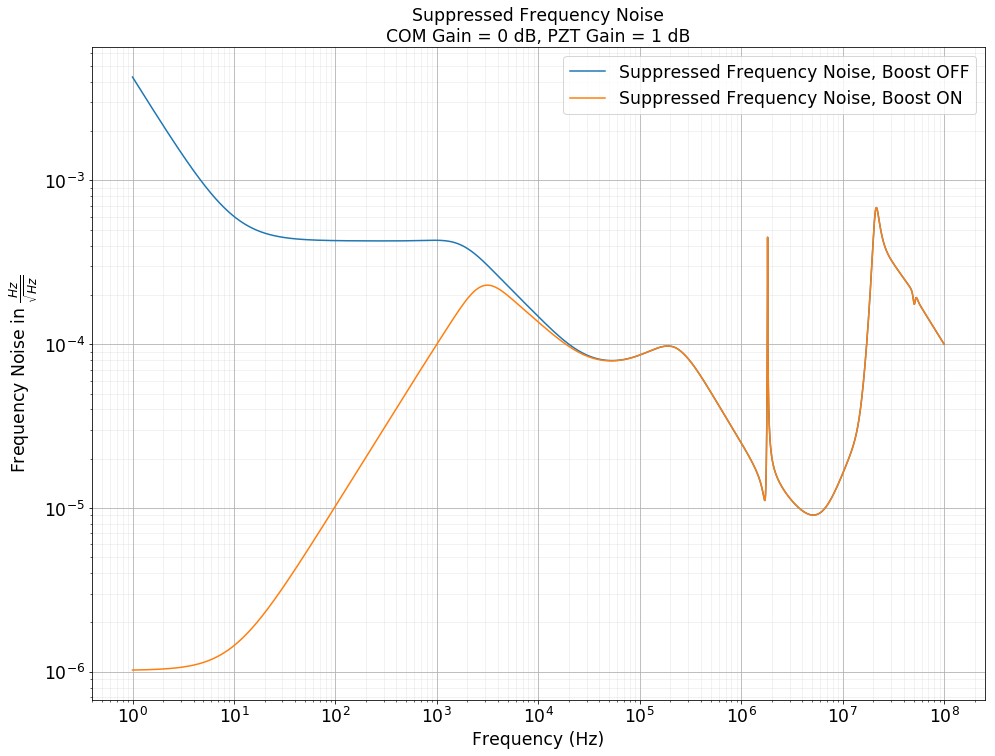

In [24]:
plotDict1b = {}
plotDict1b['Suppressed Frequency Noise, Boost ON'] = (10.0**4/ff)*plotDict1a['Suppression function, Boost ON']
plotDict1b['Suppressed Frequency Noise, Boost OFF'] = (10.0**4/ff)*plotDict1a['Suppression function, Boost OFF']
fig1b = plt.figure(figsize=[16,12])
for key,value in plotDict1b.iteritems():
    plt.loglog(ff,np.abs(value),label=key)
fig1b.gca().set_title('Suppressed Frequency Noise\nCOM Gain = '+str(COMGainValue)+' dB, PZT Gain = '+str(PZTGainValue)+' dB')
fig1b.gca().grid('on', which='both')
fig1b.gca().grid(alpha=0.2, which='minor')
fig1b.gca().legend()
fig1b.gca().set_ylabel(r'Frequency Noise in $\frac{Hz}{\sqrt{Hz}}$')
fig1b.gca().set_xlabel(r'Frequency (Hz)')
figlist +=[fig1b]

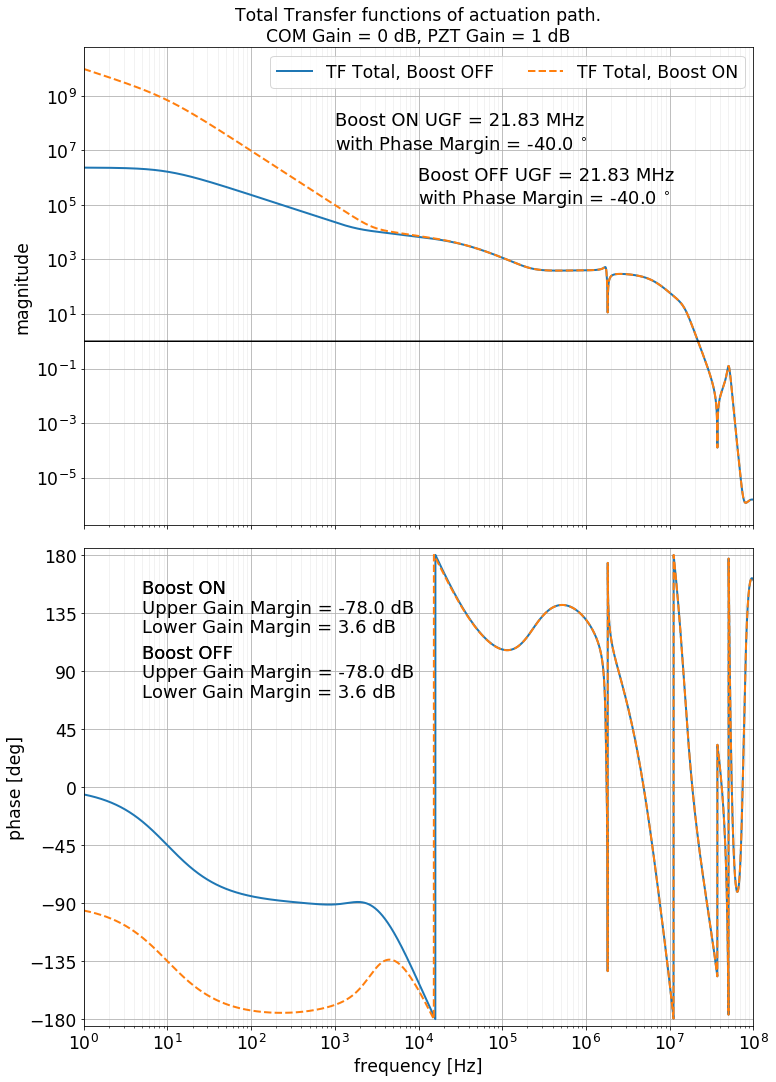

In [25]:
plotDict1c = {}
plotDict1c['TF Total, Boost ON'] = plotDict1['TF PZT Path, Boost ON']+plotDict1['TF EOM Path']
plotDict1c['TF Total, Boost OFF'] = plotDict1['TF PZT Path, Boost OFF']+plotDict1['TF EOM Path']
    
fig1c = plt.figure(figsize=[12,18])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
mag_ax = fig1c.add_subplot(gs[0])
phase_ax = fig1c.add_subplot(gs[1], sharex=mag_ax)
plotTFs(ff,plotDict1c,mag_ax=mag_ax,phase_ax=phase_ax,linewidth=2)
mag_ax.set_title('Total Transfer functions of actuation path.\nCOM Gain = '+str(COMGainValue)+' dB, PZT Gain = '+str(PZTGainValue)+' dB')
mag_ax.plot(ff,np.ones(len(ff)),c='k')
figlist +=[fig1c]

UGF = {}
ZeroPhase = {}
ffind = np.argmin(np.abs(np.abs(plotDict1c['TF Total, Boost ON'])-1))
UGF['Boost ON'] = ff[ffind]
UGF['PM, Boost ON'] = np.angle(plotDict1c['TF Total, Boost ON'][ffind])*180.0/np.pi
mag_ax.text(1e3,1e7,
            'Boost ON UGF = '+str(np.round(UGF['Boost ON']/1e6,2))+' MHz\nwith Phase Margin = '+str(np.round(UGF['PM, Boost ON']))+r' $^{\circ}$',
            fontsize=18)

if np.angle(plotDict1c['TF Total, Boost ON'][ffind])>0:
    sg=1
else:
    sg=-1
found = False
for ii in range(ffind+1,len(ff),1):
    if np.angle(plotDict1c['TF Total, Boost ON'][ii])*sg<0:
        found=True
        break
if found:
    ZeroPhase['Higher, Boost ON'] = ff[ii]
    ZeroPhase['Higher GM, Boost ON'] = 20*np.log10(np.abs(plotDict1c['TF Total, Boost ON'])[ii])
    phase_ax.text(5,150,'Boost ON',fontsize=18)
    phase_ax.text(5,135,
                 'Upper Gain Margin = '+str(np.round(ZeroPhase['Higher GM, Boost ON'],1))+' dB',
                 fontsize=18)
found = False
for ii in range(ffind-1,-1,-1):
    if np.angle(plotDict1c['TF Total, Boost ON'][ii])*sg<0:
        found=True
        break
if found:
    ZeroPhase['Lower, Boost ON'] = ff[ii]
    ZeroPhase['Lower GM, Boost ON'] = np.abs(plotDict1c['TF Total, Boost ON'])[ii]
    phase_ax.text(5,150,'Boost ON',fontsize=18)
    phase_ax.text(5,120,
                 'Lower Gain Margin = '+str(np.round(ZeroPhase['Lower GM, Boost ON'],1))+' dB',
                 fontsize=18)

ffind = np.argmin(np.abs(np.abs(plotDict1c['TF Total, Boost OFF'])-1))
UGF['Boost OFF'] = ff[ffind]
UGF['PM, Boost OFF'] = np.angle(plotDict1c['TF Total, Boost OFF'][ffind])*180.0/np.pi
mag_ax.text(1e4,1e5,
            'Boost OFF UGF = '+str(np.round(UGF['Boost OFF']/1e6,2))+' MHz\nwith Phase Margin = '+str(np.round(UGF['PM, Boost OFF']))+r' $^{\circ}$',
            fontsize=18)

if np.angle(plotDict1c['TF Total, Boost OFF'][ffind])>0:
    sg=1
else:
    sg=-1
found = False
for ii in range(ffind+1,len(ff),1):
    if np.angle(plotDict1c['TF Total, Boost OFF'][ii])*sg<0:
        found=True
        break
if found:
    ZeroPhase['Higher, Boost OFF'] = ff[ii]
    ZeroPhase['Higher GM, Boost OFF'] = 20*np.log10(np.abs(plotDict1c['TF Total, Boost OFF'])[ii])
    phase_ax.text(5,100,'Boost OFF',fontsize=18)
    phase_ax.text(5,85,
                 'Upper Gain Margin = '+str(np.round(ZeroPhase['Higher GM, Boost OFF'],1))+' dB',
                 fontsize=18)
found = False
for ii in range(ffind-1,-1,-1):
    if np.angle(plotDict1c['TF Total, Boost OFF'][ii])*sg<0:
        found=True
        break
if found:
    ZeroPhase['Lower, Boost OFF'] = ff[ii]
    ZeroPhase['Lower GM, Boost OFF'] = np.abs(plotDict1c['TF Total, Boost OFF'])[ii]
    phase_ax.text(5,100,'Boost OFF',fontsize=18)
    phase_ax.text(5,70,
                 'Lower Gain Margin = '+str(np.round(ZeroPhase['Lower GM, Boost OFF'],1))+' dB',
                 fontsize=18)

----

#### Crossover

In [26]:
plotDict2={}
plotDict2['PZT Path / EOM Path, Boost ON'] = (S_PZT/S_EOM)*FSSAnalysis['RFIN-PZTout_BoostON'].TF/FSSAnalysis['RFIN-EOMout'].TF
plotDict2['PZT Path / EOM Path, Boost OFF'] = (S_PZT/S_EOM)*FSSAnalysis['RFIN-PZTout_BoostOFF'].TF/FSSAnalysis['RFIN-EOMout'].TF

CrossoverF = {}
CrossoverF['UGF, Boost ON'] = ff[np.argmin(np.abs(np.abs(plotDict2['PZT Path / EOM Path, Boost ON'])-1))]
CrossoverF['UGF, Boost OFF'] = ff[np.argmin(np.abs(np.abs(plotDict2['PZT Path / EOM Path, Boost OFF'])-1))]
CrossoverF['PM, Boost ON'] = 180-np.abs(np.angle(plotDict2['PZT Path / EOM Path, Boost ON'][np.argmin(np.abs(np.abs(plotDict2['PZT Path / EOM Path, Boost ON'])-1))])*180/np.pi)
CrossoverF['PM, Boost OFF'] = 180-np.abs(np.angle(plotDict2['PZT Path / EOM Path, Boost OFF'][np.argmin(np.abs(np.abs(plotDict2['PZT Path / EOM Path, Boost OFF'])-1))])*180/np.pi)

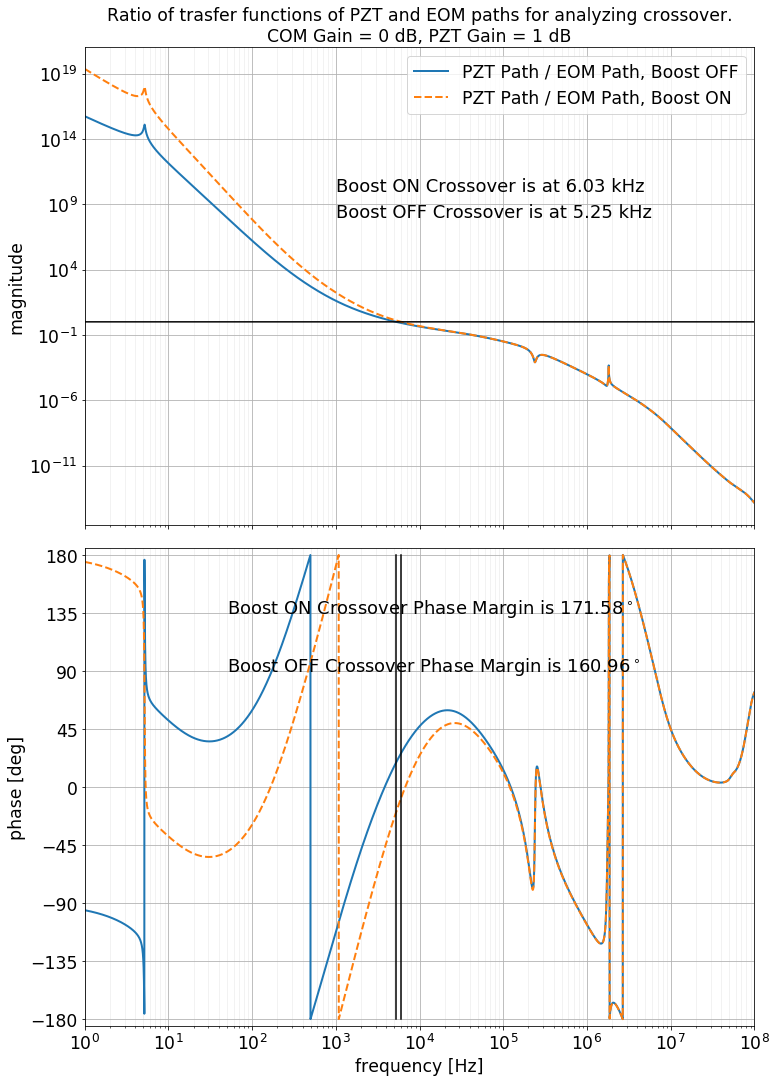

In [27]:
fig2 = plt.figure(figsize=[12,18])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
mag_ax = fig2.add_subplot(gs[0])
phase_ax = fig2.add_subplot(gs[1], sharex=mag_ax)
plotTFs(ff,plotDict2,mag_ax=mag_ax,phase_ax=phase_ax,linewidth=2)
mag_ax.set_title('Ratio of trasfer functions of PZT and EOM paths for analyzing crossover.\nCOM Gain = '+str(COMGainValue)+' dB, PZT Gain = '+str(PZTGainValue)+' dB')
mag_ax.legend(ncol=1)
mag_ax.plot(ff,np.ones(len(ff)),c='k')
mag_ax.text(1e3,1e10,'Boost ON Crossover is at '+str(np.round(CrossoverF['UGF, Boost ON']/1e3,2))+' kHz',fontsize=18)
mag_ax.text(1e3,1e8,'Boost OFF Crossover is at '+str(np.round(CrossoverF['UGF, Boost OFF']/1e3,2))+' kHz',fontsize=18)
phase_ax.plot(np.ones(2)*CrossoverF['UGF, Boost ON'],[-180,180],'k')
phase_ax.plot(np.ones(2)*CrossoverF['UGF, Boost OFF'],[-180,180],'k')
phase_ax.text(50,135,'Boost ON Crossover Phase Margin is '+str(np.round(CrossoverF['PM, Boost ON'],2))+r'$^\circ$',fontsize=18)
phase_ax.text(50,90,'Boost OFF Crossover Phase Margin is '+str(np.round(CrossoverF['PM, Boost OFF'],2))+r'$^\circ$',fontsize=18)
figlist +=[fig2]

----

#### Marking the movable poles and zeros

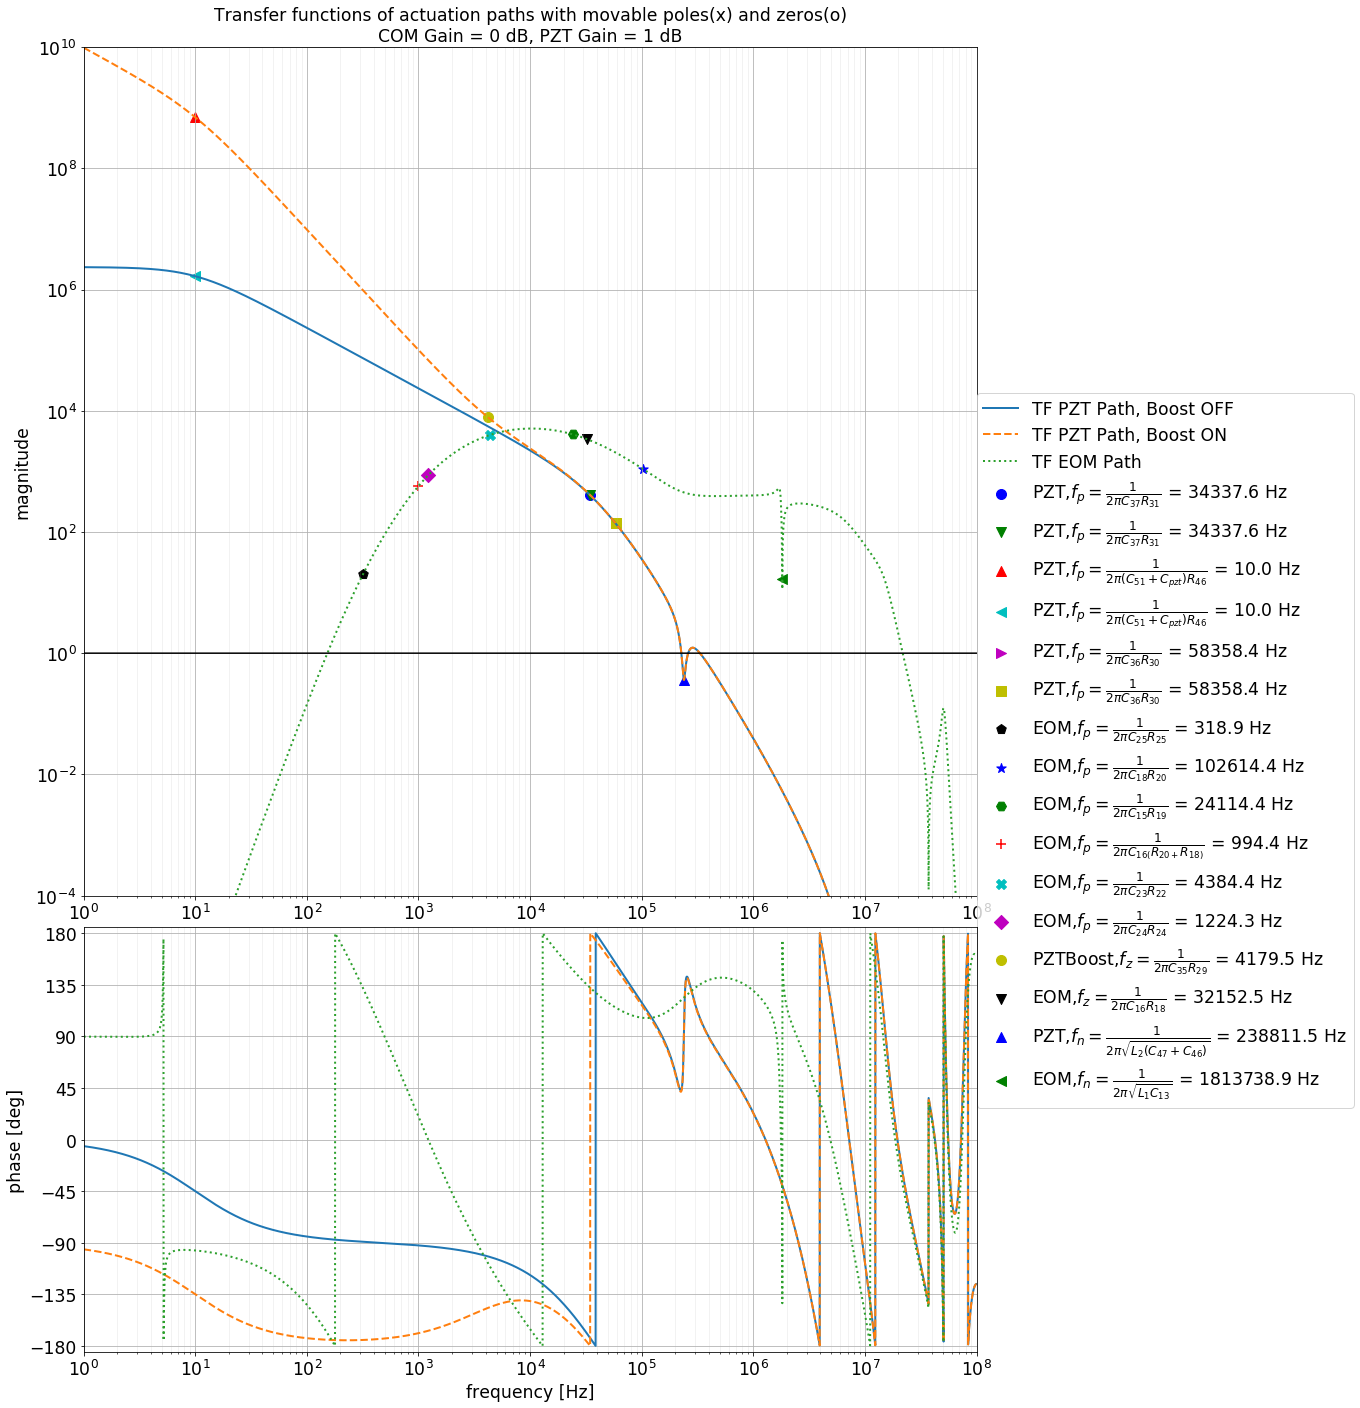

In [28]:
fig3 = plt.figure(figsize=[16,24])
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.05)
mag_ax = fig3.add_subplot(gs[0])
phase_ax = fig3.add_subplot(gs[1], sharex=mag_ax)
plotTFs(ff,plotDict1,mag_ax=mag_ax,phase_ax=phase_ax,linewidth=2)
mag_ax.set_title('Transfer functions of actuation paths with movable poles(x) and zeros(o)\nCOM Gain = '+str(COMGainValue)+' dB, PZT Gain = '+str(PZTGainValue)+' dB')
mag_ax.plot(ff,np.ones(len(ff)),c='k')
xmin,xmax = mag_ax.get_xlim()


mi = 0
ci = 0
for key,value in PZTpoles.iteritems():
    if value<xmax and value>xmin:
        Lb = key+r' = '+str(np.round(value,1))+r' Hz'
        mag_ax.scatter(value,np.abs(plotDict1['TF PZT Path, Boost ON'][np.argmin(np.abs(ff-value))]),
                       s=100,label=Lb,marker=mList[mi],c=cList[ci])
        mi = np.mod(mi+1,12)
        ci = np.mod(ci+1,7)
        #mag_ax.text(value,np.abs(plotDict1['TF PZT Path, Boost ON'][np.argmin(np.abs(ff-value))]),key,fontsize=14)
        mag_ax.scatter(value,np.abs(plotDict1['TF PZT Path, Boost OFF'][np.argmin(np.abs(ff-value))]),
                       s=100,label=Lb,marker=mList[mi],c=cList[ci])
        mi = np.mod(mi+1,12)
        ci = np.mod(ci+1,7)

for key,value in PZTBoostpoles.iteritems():
    if value<xmax and value>xmin:
        Lb = key+r' = '+str(np.round(value,1))+r' Hz'
        mag_ax.scatter(value,np.abs(plotDict1['TF PZT Path, Boost ON'][np.argmin(np.abs(ff-value))]),
                       s=100,label=Lb,marker=mList[mi],c=cList[ci])
        mi = np.mod(mi+1,12)
        ci = np.mod(ci+1,7)
        #mag_ax.text(value,np.abs(plotDict1['TF PZT Path, Boost ON'][np.argmin(np.abs(ff-value))]),key,fontsize=14)
        
for key,value in EOMpoles.iteritems():
    if value<xmax and value>xmin:
        Lb = key+r' = '+str(np.round(value,1))+r' Hz'
        mag_ax.scatter(value,np.abs(plotDict1['TF EOM Path'][np.argmin(np.abs(ff-value))]),
                       s=100,label=Lb,marker=mList[mi],c=cList[ci])
        mi = np.mod(mi+1,12)
        ci = np.mod(ci+1,7)
        #mag_ax.text(value,np.abs(plotDict1['TF EOM Path'][np.argmin(np.abs(ff-value))]),key,fontsize=14,rotation=90,color='g')

for key,value in PZTzeros.iteritems():
    if value<xmax and value>xmin:
        Lb = key+r' = '+str(np.round(value,1))+r' Hz'
        mag_ax.scatter(value,np.abs(plotDict1['TF PZT Path, Boost ON'][np.argmin(np.abs(ff-value))]),
                       s=100,label=Lb,marker=mList[mi],c=cList[ci])
        mi = np.mod(mi+1,12)
        ci = np.mod(ci+1,7)
        #mag_ax.text(value,np.abs(plotDict1['TF PZT Path, Boost ON'][np.argmin(np.abs(ff-value))]),key,fontsize=14,rotation=0)
        mi = np.mod(mi+1,12)
        ci = np.mod(ci+1,7)
        mag_ax.scatter(value,np.abs(plotDict1['TF PZT Path, Boost OFF'][np.argmin(np.abs(ff-value))]),
                       s=100,label=Lb,marker=mList[mi],c=cList[ci])
for key,value in PZTBoostzeros.iteritems():
    if value<xmax and value>xmin:
        Lb = key+r' = '+str(np.round(value,1))+r' Hz'
        mag_ax.scatter(value,np.abs(plotDict1['TF PZT Path, Boost ON'][np.argmin(np.abs(ff-value))]),
                       s=100,label=Lb,marker=mList[mi],c=cList[ci])
        mi = np.mod(mi+1,12)
        ci = np.mod(ci+1,7)
        #mag_ax.text(value,np.abs(plotDict1['TF PZT Path, Boost ON'][np.argmin(np.abs(ff-value))]),key,fontsize=14,rotation=0)

for key,value in EOMzeros.iteritems():
    if value<xmax and value>xmin:
        Lb = key+r' = '+str(np.round(value,1))+r' Hz'
        mag_ax.scatter(value,np.abs(plotDict1['TF EOM Path'][np.argmin(np.abs(ff-value))]),
                       s=100,label=Lb,marker=mList[mi],c=cList[ci])
        mi = np.mod(mi+1,12)
        ci = np.mod(ci+1,7)
        #mag_ax.text(value,np.abs(plotDict1['TF EOM Path'][np.argmin(np.abs(ff-value))]),key,fontsize=14,rotation=45)

for key,value in PZTnotch.iteritems():
    if value<xmax and value>xmin:
        Lb = key+r' = '+str(np.round(value,1))+r' Hz'
        mag_ax.scatter(value,np.abs(plotDict1['TF PZT Path, Boost ON'][np.argmin(np.abs(ff-value))]),
                       s=100,label=Lb,marker=mList[mi],c=cList[ci])
        mi = np.mod(mi+1,12)
        ci = np.mod(ci+1,7)

for key,value in EOMnotch.iteritems():
    if value<xmax and value>xmin:
        Lb = key+r' = '+str(np.round(value,1))+r' Hz'
        mag_ax.scatter(value,np.abs(plotDict1['TF EOM Path'][np.argmin(np.abs(ff-value))]),
                       s=100,label=Lb,marker=mList[mi],c=cList[ci])
        mi = np.mod(mi+1,12)
        ci = np.mod(ci+1,7)
        #mag_ax.text(value,np.abs(plotDict1['TF EOM Path'][np.argmin(np.abs(ff-value))]),key,fontsize=14,rotation=45)

mag_ax.set_ylim((1e-4,1e10))
mag_ax.legend(ncol=1,loc=(1,-0.25))
plt.setp(mag_ax.get_xticklabels(), visible=True)
figlist +=[fig3]

## Parametric Analysis

How does changing gain values affect the results?

Here, I ramp the pzt gain to see what cross-over frequencies and phase margin's we get in the whole range with present values of poles and zeros.

----
### Boost ON


In [29]:
paramAnalysis={}
gainValues = np.arange(-10,30.1,0.25)
COF = np.zeros(len(gainValues))
PM = np.zeros(len(gainValues))
COMGain(FSS,G=0)
FSS.computeTF('rfbn1', 'eomHVn11', fflow, ffhigh, numPoints)
EOMTF = FSS.TF
PZTBoost(FSS,'ON')
ii=0
for ii,pztGain in enumerate(gainValues):
    PZTGain(FSS,G=pztGain,vb=False)
    FSS.computeTF('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
    RTF = S_PZT*FSS.TF/EOMTF/S_EOM
    ffind = np.argmin(np.abs(np.abs(RTF)-1))
    COF[ii] = ff[ffind]
    PM[ii] = np.angle(RTF[ffind])*180.0/np.pi
paramAnalysis['var PZTG, COMG=0dB, Boost ON'] = [COF,PM]

Setting common gain:
Gain set to 0 dB.
PZT Boost is ON.


----
### Boost OFF


In [30]:
PZTBoost(FSS,'OFF')
COF = np.zeros(len(gainValues))
PM = np.zeros(len(gainValues))
ii=0
for ii,pztGain in enumerate(gainValues):
    PZTGain(FSS,G=pztGain,vb=False)
    FSS.computeTF('rfbn1', 'pztn17', fflow, ffhigh, numPoints)
    RTF = S_PZT*FSS.TF/EOMTF/S_EOM
    ffind = np.argmin(np.abs(np.abs(RTF)-1))
    COF[ii] = ff[ffind]
    PM[ii] = np.angle(RTF[ffind])*180.0/np.pi
paramAnalysis['var PZTG, COMG=0dB, Boost OFF'] = [COF,PM]

PZT Boost is OFF.


----

### Plotting the results:

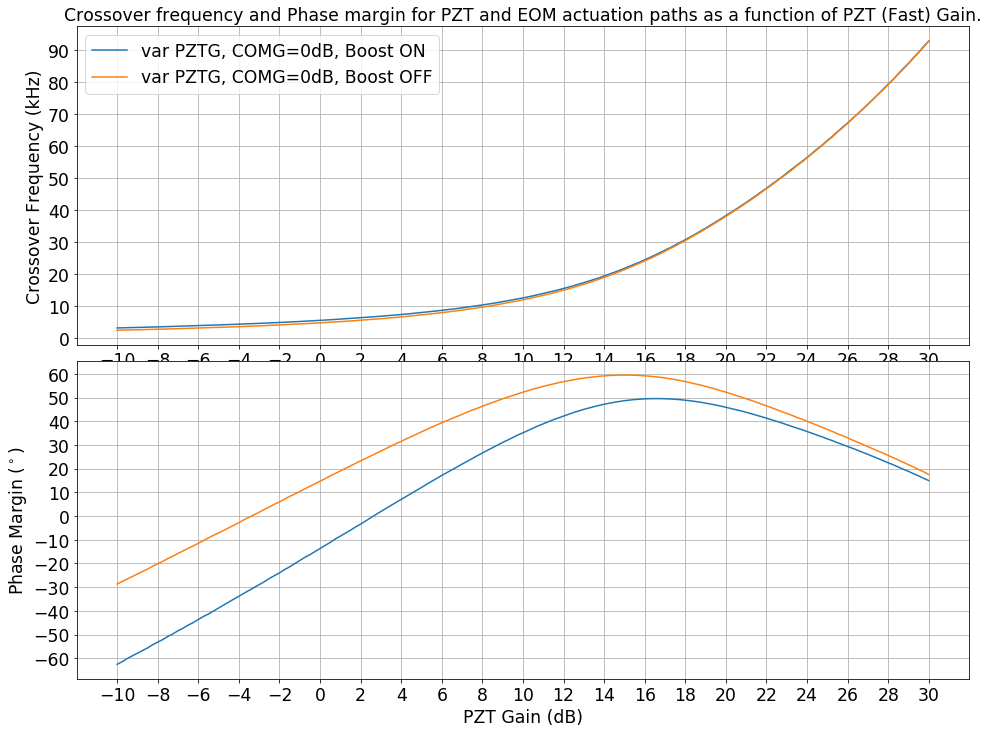

In [31]:
fig4 = plt.figure(figsize=[16,12])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.05)
cof_ax = fig4.add_subplot(gs[0])
pm_ax = fig4.add_subplot(gs[1])
for key,value in paramAnalysis.iteritems():
    cof_ax.plot(gainValues,value[0]/1e3,label=key)
    pm_ax.plot(gainValues,value[1],label=key)
cof_ax.legend()
cof_ax.set_ylabel('Crossover Frequency (kHz)')
pm_ax.set_ylabel(r'Phase Margin ($^\circ$)')
pm_ax.set_xlabel('PZT Gain (dB)')
cof_ax.set_title('Crossover frequency and Phase margin for PZT and EOM actuation paths as a function of PZT (Fast) Gain.')
cof_ax.grid('on', which='both')
cof_ax.grid(alpha=0.2, which='minor')
cof_ax.set_yticks(np.arange(0,100,10))
pm_ax.set_yticks(np.arange(-60,65,10))
cof_ax.set_xticks(np.arange(-10,31,2))
pm_ax.set_xticks(np.arange(-10,31,2))
pm_ax.grid('on', which='both')
pm_ax.grid(alpha=0.2, which='minor')
figlist += [fig4]

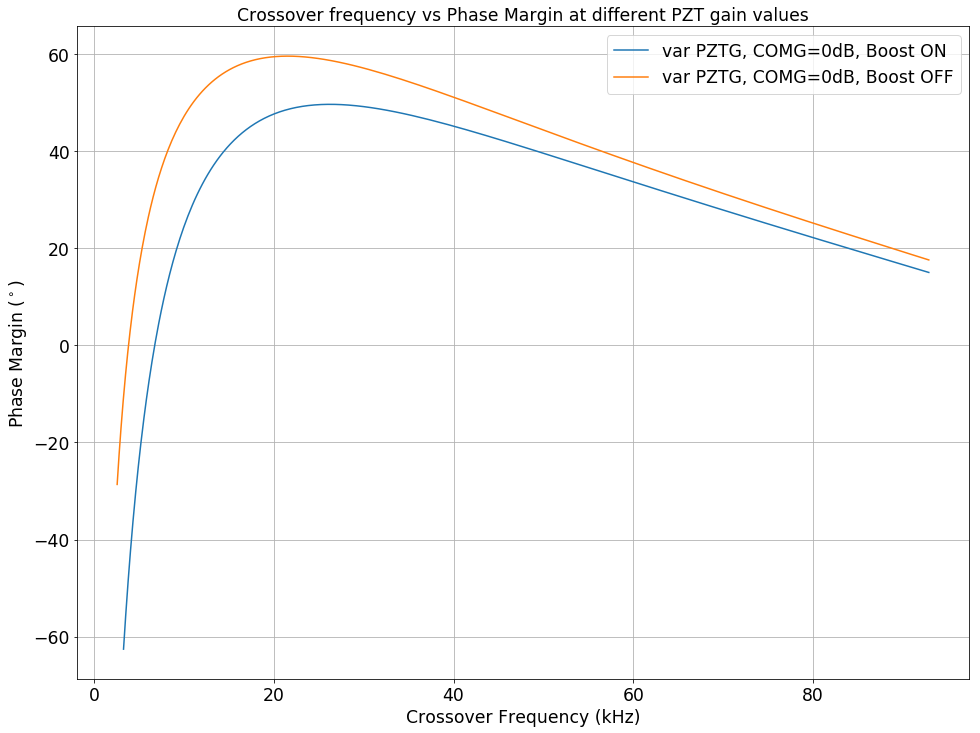

In [32]:
fig4a = plt.figure(figsize=[16,12])
for key,value in paramAnalysis.iteritems():
    plt.plot(value[0]/1e3,value[1],label=key)
fig4a.gca().set_title('Crossover frequency vs Phase Margin at different PZT gain values')
fig4a.gca().grid('on', which='both')
fig4a.gca().grid(alpha=0.2, which='minor')
fig4a.gca().legend()
fig4a.gca().set_ylabel(r'Phase Margin ($^\circ$)')
fig4a.gca().set_xlabel(r'Crossover Frequency (kHz)')
figlist +=[fig4a]

## Load on EOM

Given that everything happens as ideally as calculated above, then what is the rms load on for actuation. That is what is the rms control signal sent to EOM. We want to know f this is larger than the maximum possible $V_\pi$ voltage that EOM takes otherwise EOM will just rail and above mentioned calculations will happen only in jupyter notebook.


In [33]:
Vpi = np.pi/ms   #ms is the modulation slope of EOM defined above

#Actuation signal of EOM from suppressed noise in V/rtHz
EOMActSig={}
EOMActSig['Boost ON'] = plotDict1['TF EOM Path']*plotDict1b['Suppressed Frequency Noise, Boost ON']/S_EOM
EOMActSig['Boost OFF'] = plotDict1['TF EOM Path']*plotDict1b['Suppressed Frequency Noise, Boost OFF']/S_EOM

In [34]:
EOMActSigRMS = {}
EOMActSigRMS['Boost ON'] = np.sqrt(np.sum((np.abs(EOMActSig['Boost ON'][:-1])**2)*(ff[1:]-ff[:-1])))
EOMActSigRMS['Boost OFF'] = np.sqrt(np.sum((np.abs(EOMActSig['Boost ON'][:-1])**2)*(ff[1:]-ff[:-1])))
print('Boost ON, RMS actuation signal of EOM is '+str(np.round(EOMActSigRMS['Boost ON'],2))+' V')
print('Boost OFF, RMS actuation signal of EOM is '+str(np.round(EOMActSigRMS['Boost OFF'],2))+' V')

Boost ON, RMS actuation signal of EOM is 1.01 V
Boost OFF, RMS actuation signal of EOM is 1.01 V


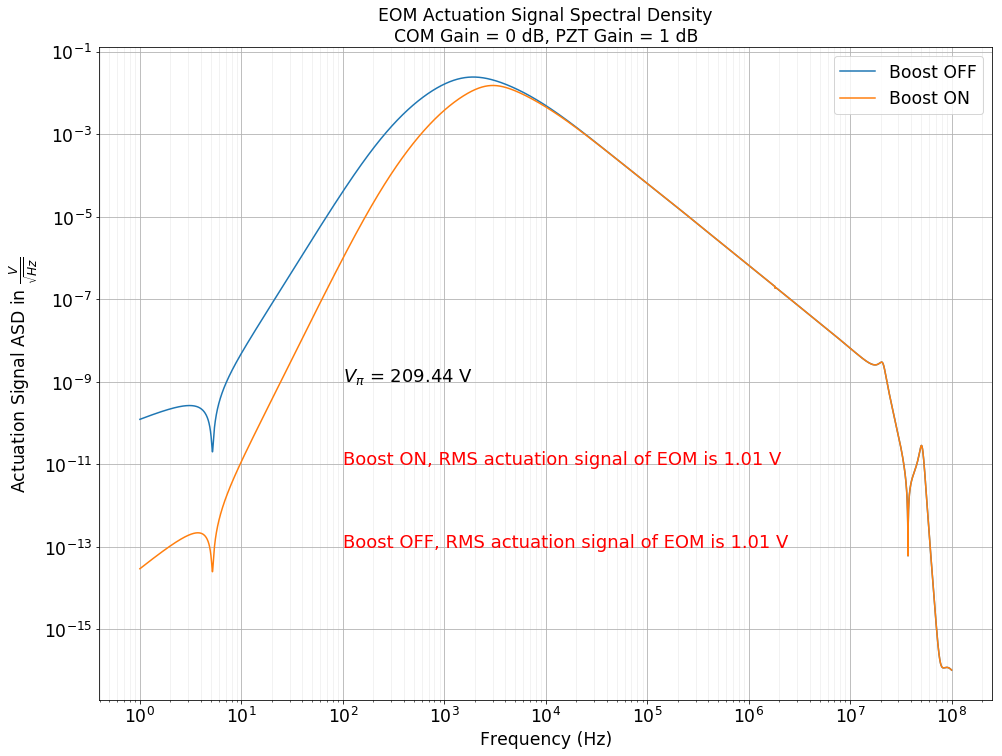

In [35]:
fig5 = plt.figure(figsize=[16,12])
for key,value in EOMActSig.iteritems():
    plt.loglog(ff,np.abs(value),label=key)
fig5.gca().set_title('EOM Actuation Signal Spectral Density\nCOM Gain = '+str(COMGainValue)+' dB, PZT Gain = '+str(PZTGainValue)+' dB')
fig5.gca().grid('on', which='both')
fig5.gca().grid(alpha=0.2, which='minor')
fig5.gca().legend()
fig5.gca().set_ylabel(r'Actuation Signal ASD in $\frac{V}{\sqrt{Hz}}$')
fig5.gca().set_xlabel(r'Frequency (Hz)')
fig5.gca().text(1e2,1e-9,r'$V_{\pi}$ = '+str(np.round(Vpi,2))+' V',fontsize=18)
fig5.gca().text(1e2,1e-11,'Boost ON, RMS actuation signal of EOM is '+str(np.round(EOMActSigRMS['Boost ON'],2))+' V',color='r',fontsize=18)
fig5.gca().text(1e2,1e-13,'Boost OFF, RMS actuation signal of EOM is '+str(np.round(EOMActSigRMS['Boost OFF'],2))+' V',color='r',fontsize=18)
figlist +=[fig5]

In [36]:
pp = PdfPages('FSS_Modified_Analysis.pdf')
for fig in figlist:
    pp.savefig(fig,bbox_inches='tight')
pp.close()